In [1]:
import glob
import scipy.io
import os
import scipy.stats
import time
%load_ext autoreload
%autoreload 2

In [2]:
import sklearn.neighbors
from scipy.cluster.vq import whiten
from scipy.sparse import csr_matrix, find
import scipy.io

In [3]:
import sys
sys.path.append('/Users/rsingh/Oyla/Work/our_python_dev/')
from oyla.mvc.filters import *

In [4]:
import open3d as o3d
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline
from oyla.mvc.utils import *

In [265]:
dir_path='/Volumes/Samsung_T5/Backup//Oyla/02 Technical/'+'10 Data/44x33/oyla_1_camera_v2/RHouse_RHD_March_31_20_00_44/////'

In [266]:
input_data_folder_name =  dir_path
csv_file = input_data_folder_name+'/parameters.csv'
parameters = read_csv_parameters(csv_file)
filter_params = {}
ambiguity_distance, range_max, range_min, saturation_flag, adc_flag, mod_freq, ampl_min,reflectivity_thresh = some_common_utility(parameters,0)
reflectivity_thresh=0

dict_keys(['Section', 'Type', 'Key', 'Argument Format', 'Value', 'Command Group', 'Description'])


In [267]:
filter_params = {}
filter_parameters = {}
filter_parameters['filter_cmd'] = {}
filter_parameters = read_csv_parameters("/Users/rsingh/Oyla/Work/our_python_dev/oyla/mvc/filter_params.csv")
for k in filter_parameters['filter_cmd'].keys():
        #print(parameters['filter_cmd'][k][self.epoch_number])
        try:
                filter_params[k] = int(filter_parameters['filter_cmd'][k][0])
                #parameters['filter_cmd'][k][0] = filter_parameters['filter_cmd'][k][0]
        except ValueError:
                pass
filter_params = {}

dict_keys(['Section', 'Type', 'Key', 'Argument Format', 'Value', 'Command Group', 'Description'])


In [ ]:
a = np.N

In [272]:
index = np.random.randint(0,100)
#index = 66
#index = 162
print(index)
pcd = o3d.io.read_point_cloud(os.path.join(dir_path,'kitti/')+'/3d/oyla_'+str(index).zfill(4)+'.xyz',format='xyz')
data = scipy.io.loadmat(dir_path+'/data_1_'+str(index)+'.mat')['data']
data2 = scipy.io.loadmat(dir_path+'/data_1_'+str(index+1)+'.mat')['data']
rgb = data2[0][4]
raw_phase = data[0][2][0][0][:,:,0]
raw_ampl = data[0][2][0][0][:,:,1]
rgb,raw_phase,raw_ampl = camera_calibrations(rgb,depth=raw_phase,ampl=raw_ampl,camera_version='oyla_1_camera_v2')
#raw_phase = cv2.resize(raw_phase,(512,64))
#raw_ampl = cv2.resize(raw_ampl,(512,64))
#_rgb = cv2.resize(rgb,None,fx=120/212,fy=120/212)

filtered_phase, thresholded_ampl, indices = threshold_filter(raw_phase = raw_phase, raw_ampl = raw_ampl, reflectivity_thresh= reflectivity_thresh,
                                                            range_max = range_max, range_min = range_min, ampl_min = ampl_min,
                                                            filter_params = filter_params, ambiguity_distance = ambiguity_distance)
#filtered_phase = np.rot90(filtered_phase)
#thresholded_ampl = np.rot90(thresholded_ampl)
_filtered_phase = filtered_phase.astype('float32')/np.max(filtered_phase)
_thresholded_ampl = thresholded_ampl.astype('float32')/np.max(thresholded_ampl)
_rgb = cv2.resize(rgb,(_filtered_phase.shape[1],_filtered_phase.shape[0]))
_rgb = _rgb.astype('float32')/255.0

84


In [273]:
_r = np.squeeze(_rgb[:,:,0])[np.where(_filtered_phase>0)]
_g = np.squeeze(_rgb[:,:,1])[np.where(_filtered_phase>0)]
_b = np.squeeze(_rgb[:,:,2])[np.where(_filtered_phase>0)]

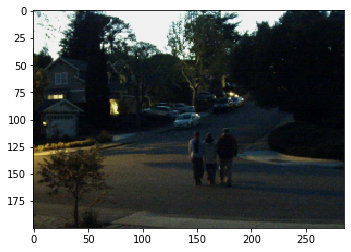

In [274]:
plt.imshow(_rgb)

In [279]:
o3d.visualization.draw_geometries([pcd])

In [315]:
cmap = plt.get_cmap("tab20")

labels = np.array(pcd.cluster_dbscan(eps=100, min_points=10, print_progress=True))
max_label = labels.max()
print("has %d clusters" % (max_label + 1))

colors = cmap(labels / (max_label if max_label > 0 else 1))
colors[labels <0] = 0
pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])
o3d.visualization.draw_geometries([pcd])

has 10 clusters


In [13]:
# https://stackoverflow.com/a/45313353/ @Divakar
def view1D(a, b): # a, b are arrays
    a = np.ascontiguousarray(a)
    b = np.ascontiguousarray(b)
    void_dt = np.dtype((np.void, a.dtype.itemsize * a.shape[1]))
    return a.view(void_dt).ravel(),  b.view(void_dt).ravel()

def setdiff_nd(a,b):
    # a,b are the nD input arrays
    A,B = view1D(a,b)    
    return a[~np.isin(A,B)]

In [25]:
np.where(filtered_phase==303)

(array([158, 158, 159, 159]), array([164, 165, 164, 165]))

In [316]:
np.unique(labels,return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9], dtype=int32),
 array([   45,   552,  9368,    16,    12,    52,    40,    20,    33,
        15490,   180]))

In [15]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [69]:
features = np.hstack((np.asarray(pcd.points),_r[:,np.newaxis],_g[:,np.newaxis],_b[:,np.newaxis]))
X = features

In [63]:
features = np.hstack((_r[:,np.newaxis],_g[:,np.newaxis],_b[:,np.newaxis]))
X = features

In [325]:
features = np.asarray(pcd.points)
X = features

In [326]:
print(np.where(features[:,0]>np.median(features[:,0]))[0])
X = features[np.where(features[:,0]<np.median(features[:,0]))[0],:]
X = X[:,[1,2]]
X.shape

[ 8048  8049  8466 ... 25805 25806 25807]


(12904, 2)

In [327]:
np.std(X,axis=0)

array([ 550.56003682, 1056.76375979])

In [328]:
X = StandardScaler().fit_transform(X)

In [329]:
db = DBSCAN(eps=0.1, min_samples=10).fit(X)
#labels = db.labels_
labels = np.ones_like(features[:,0])*-1
print(labels.shape)
labels[np.where(features[:,0]<np.median(features[:,0]))[0]] = db.labels_

(25808,)


In [330]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)


Estimated number of clusters: 13
Estimated number of noise points: 12926


In [331]:
    np.unique(labels,return_counts=True)

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.,
        12.]),
 array([12926,  3180,  8246,    16,    12,    28,    24,    40,    22,
           40,    48,  1186,    26,    14]))

In [332]:
max_label = labels.max()
print("has %d clusters" % (max_label + 1))

colors = cmap(labels / (max_label if max_label > 0 else 1))
colors[labels<0] = 0
pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])
o3d.visualization.draw_geometries([pcd])

has 13 clusters


In [295]:
xyz = np.asarray(pcd.points)
X = xyz[:,0]
Y = xyz[:,1]
Z = xyz[:,2]
max(X)

422.12476

(array([  11.,   12.,   11.,   14.,   12.,   22.,   22.,   32.,   31.,
          43.,   38.,   54.,   43.,   65.,   79.,   92.,  101.,  104.,
         103.,  104.,  102.,  131.,  111.,  112.,  125.,  123.,  135.,
         115.,  130.,  142.,  124.,  115.,  130.,  136.,  113.,  134.,
         125.,  109.,  127.,  125.,  113.,  122.,  119.,  114.,  112.,
         112.,  124.,  133.,  177.,  228.,  196.,  146.,  178.,  159.,
         171.,  116.,  115.,   99.,  117.,  106.,  127.,   92.,  118.,
          90.,   85.,   78.,   54.,   54.,   48.,   58.,   38.,   42.,
          72.,   62.,   44.,   40.,   22.,   74.,   96.,  174.,  334.,
         469.,  548.,  552.,  526.,  529.,  538.,  554.,  465.,  469.,
         443.,  399.,  399.,  451., 1161., 2112., 2224., 2235., 2644.,
        1074.]), array([-838.11005  , -825.5077019, -812.9053538, -800.3030057,
        -787.7006576, -775.0983095, -762.4959614, -749.8936133,
        -737.2912652, -724.6889171, -712.086569 , -699.4842209,
        -68

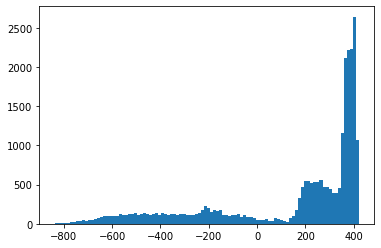

In [276]:
plt.hist(X,100)

In [277]:
np.median(X)

302.18525

In [112]:
from skimage.segmentation import felzenszwalb

178


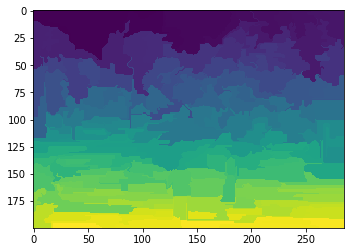

In [119]:
_fez = felzenszwalb(_rgb,scale=2, sigma=1.0, min_size=70)
print(np.max(np.unique(_fez)))
plt.imshow((_fez))

In [ ]:
800/(200*286)

In [12]:
import glob
files = []
files.extend(glob.glob('/Users/rsingh/Oyla/Data/RHouse_RHD_March_31_20_00_44//*/*/*/all.mat'))
files.extend(glob.glob('/Users/rsingh/Oyla/Data/RHouse_RHD_March_31_20_00_44/*/*/all.mat'))
files.extend(glob.glob('/Users/rsingh/Oyla/Data/RHouse_RHD_March_31_20_00_44/*/all.mat'))
#print(files)
L = {}
for f in files:
    usz = 800
    lsz = 50
    if 'cds' in f:
        usz = 800/(200*286)*(196*320)
        lsz = 50/(200*286)*(196*320)
    if 'dus' in f:
        usz = 800/(200*286)*(360*588)
        lsz = 50/(200*286)*(360*588)
    A = scipy.io.loadmat(f)
    key = '_'.join(f.split('/')[-4:-2])
    L[key] = []
    for i in range(999): 
        co = A[str(i+1)][2:,:] 
        sz = A[str(i+1)][1,:]
        dist=[] 
        szz = sz[1:][(sz[1:]<usz) & (sz[1:]>lsz)]
        
        L[key].append(len(szz))
    print(L.keys())

dict_keys(['filtered_data_July_06_06_29_06_median_outlier_temporal_filter_8'])
dict_keys(['filtered_data_July_06_06_29_06_median_outlier_temporal_filter_8', 'temporal_filter_8_filtered_data_July_07_18_00_09_median_outlier'])
dict_keys(['filtered_data_July_06_06_29_06_median_outlier_temporal_filter_8', 'temporal_filter_8_filtered_data_July_07_18_00_09_median_outlier', 'temporal_filter_8_filtered_data_July_15_06_35_01_outlier'])
dict_keys(['filtered_data_July_06_06_29_06_median_outlier_temporal_filter_8', 'temporal_filter_8_filtered_data_July_07_18_00_09_median_outlier', 'temporal_filter_8_filtered_data_July_15_06_35_01_outlier', 'RHouse_RHD_March_31_20_00_44_filtered_data_July_03_16_05_58_median_edge'])
dict_keys(['filtered_data_July_06_06_29_06_median_outlier_temporal_filter_8', 'temporal_filter_8_filtered_data_July_07_18_00_09_median_outlier', 'temporal_filter_8_filtered_data_July_15_06_35_01_outlier', 'RHouse_RHD_March_31_20_00_44_filtered_data_July_03_16_05_58_median_edge', 'RHouse_

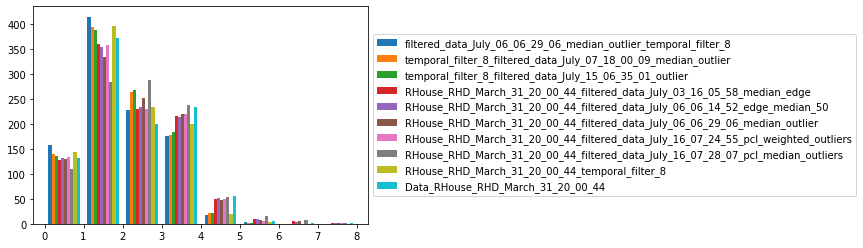

In [13]:
plt.hist(np.array(list(L.values())).transpose(),[0,1,2,3,4,5,6,7,8])

#plt.legend(L.keys())
plt.legend(L.keys(),loc='center left', bbox_to_anchor=(1, 0.5))
#print(L.keys())
#plt.grid('on')

In [57]:
import glob
files = []
files.extend(glob.glob('/Users/rsingh/Oyla/Data/RHouse_RH_February_07_18_54_22/*/*/*/depth_mask_seg.mat'))
files.extend(glob.glob('/Users/rsingh/Oyla/Data/RHouse_RH_February_07_18_54_22/*/*/depth_mask_seg.mat'))
files.extend(glob.glob('/Users/rsingh/Oyla/Data/RHouse_RH_February_07_18_54_22/*/depth_mask_seg.mat'))
#print(files)
L = {}
for f in files:
    usz = 800
    lsz = 50
    if 'cds' in f:
        usz = 800/(200*286)*(196*320)
        lsz = 50/(200*286)*(196*320)
    if 'dus' in f:
        usz = 800/(200*286)*(360*588)
        lsz = 50/(200*286)*(360*588)
    A = scipy.io.loadmat(f)
    key = '_'.join(f.split('/')[-4:-2])
    L[key] = []
    for i in range(999): 
        co = A[str(i+1)][2:,:] 
        sz = A[str(i+1)][1,:]
        dist=[] 
        szz = sz[1:][(sz[1:]<usz) & (sz[1:]>lsz)]
        
        L[key].append(len(szz))
    print(L.keys())

dict_keys(['filtered_data_July_14_15_16_00_median_outlier_temporal_filter_8'])
dict_keys(['filtered_data_July_14_15_16_00_median_outlier_temporal_filter_8', 'temporal_filter_8_filtered_data_July_14_15_20_23_median_outlier'])
dict_keys(['filtered_data_July_14_15_16_00_median_outlier_temporal_filter_8', 'temporal_filter_8_filtered_data_July_14_15_20_23_median_outlier', 'temporal_filter_8_filtered_data_July_14_17_25_08_outlier'])
dict_keys(['filtered_data_July_14_15_16_00_median_outlier_temporal_filter_8', 'temporal_filter_8_filtered_data_July_14_15_20_23_median_outlier', 'temporal_filter_8_filtered_data_July_14_17_25_08_outlier', 'RHouse_RH_February_07_18_54_22_filtered_data_July_14_15_16_00_median_outlier'])
dict_keys(['filtered_data_July_14_15_16_00_median_outlier_temporal_filter_8', 'temporal_filter_8_filtered_data_July_14_15_20_23_median_outlier', 'temporal_filter_8_filtered_data_July_14_17_25_08_outlier', 'RHouse_RH_February_07_18_54_22_filtered_data_July_14_15_16_00_median_outlier'

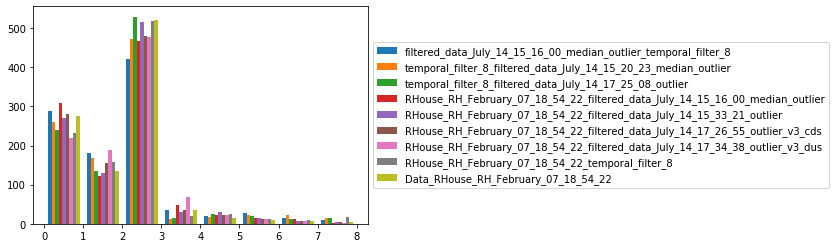

In [58]:
plt.hist(np.array(list(L.values())).transpose(),[0,1,2,3,4,5,6,7,8])

#plt.legend(L.keys())
plt.legend(L.keys(),loc='center left', bbox_to_anchor=(1, 0.5))
#print(L.keys())
#plt.grid('on')

In [9]:
import glob
files = []
#files.extend(glob.glob('/Users/rsingh/Oyla/Data/RHouse_RHD_March_31_19_25_36//*/*/*/depth_mask_seg.mat'))
#files.extend(glob.glob('/Users/rsingh/Oyla/Data/RHouse_RHD_March_31_19_25_36/*/*/depth_mask_seg.mat'))
files.extend(glob.glob('/Users/rsingh/Oyla/Data/RHouse_RHD_March_31_19_25_36/*/depth_mask_seg*.mat'))
#print(files)
L = {}
for f in files:
    usz = 800
    lsz = 50
    if 'cds' in f:
        usz = 800/(200*286)*(196*320)
        lsz = 50/(200*286)*(196*320)
    if 'dus' in f:
        usz = 800/(200*286)*(360*588)
        lsz = 50/(200*286)*(360*588)
    A = scipy.io.loadmat(f)
    key = '_'.join(f.split('/')[-4:])
    L[key] = []
    for i in range(999): 
        co = A[str(i+1)][2:,:] 
        sz = A[str(i+1)][1,:]
        dist=[] 
        szz = sz[1:][(sz[1:]<usz) & (sz[1:]>lsz)]
        
        L[key].append(len(szz))
    print(L.keys())

dict_keys(['Data_RHouse_RHD_March_31_19_25_36_collateral_depth_mask_seg.mat'])
dict_keys(['Data_RHouse_RHD_March_31_19_25_36_collateral_depth_mask_seg.mat', 'Data_RHouse_RHD_March_31_19_25_36_collateral_depth_mask_seg_cds.mat'])
dict_keys(['Data_RHouse_RHD_March_31_19_25_36_collateral_depth_mask_seg.mat', 'Data_RHouse_RHD_March_31_19_25_36_collateral_depth_mask_seg_cds.mat', 'Data_RHouse_RHD_March_31_19_25_36_collateral_depth_mask_seg_dus.mat'])


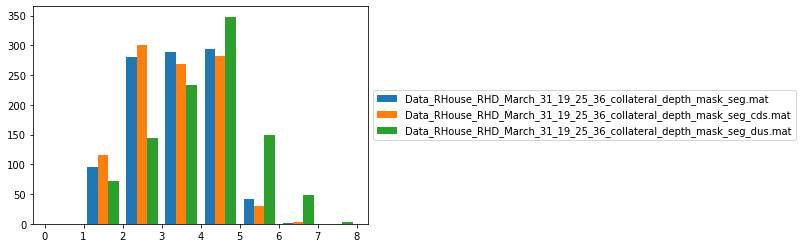

In [10]:
plt.hist(np.array(list(L.values())).transpose(),[0,1,2,3,4,5,6,7,8])

#plt.legend(L.keys())
plt.legend(L.keys(),loc='center left', bbox_to_anchor=(1, 0.5))
#print(L.keys())
#plt.grid('on')

In [11]:
np.where((np.asarray(L['Data_RHouse_RHD_March_31_19_25_36_collateral_depth_mask_seg_dus.mat'])==6) & (np.asarray(L['Data_RHouse_RHD_March_31_19_25_36_collateral_depth_mask_seg.mat'])!=6))

(array([564, 566, 572, 574, 579, 580, 582, 589, 590, 591, 592, 593, 594,
        595, 596, 597, 598, 600, 601, 602, 603, 606, 607, 608, 609, 610,
        611, 613, 617, 626, 627, 628, 636, 685, 861, 891, 926, 928, 930,
        935, 936, 938, 939, 941, 945, 957, 967, 991]),)

In [77]:
L['RHouse_RHD_March_31_19_25_36_temporal_filter_4'][162]

0

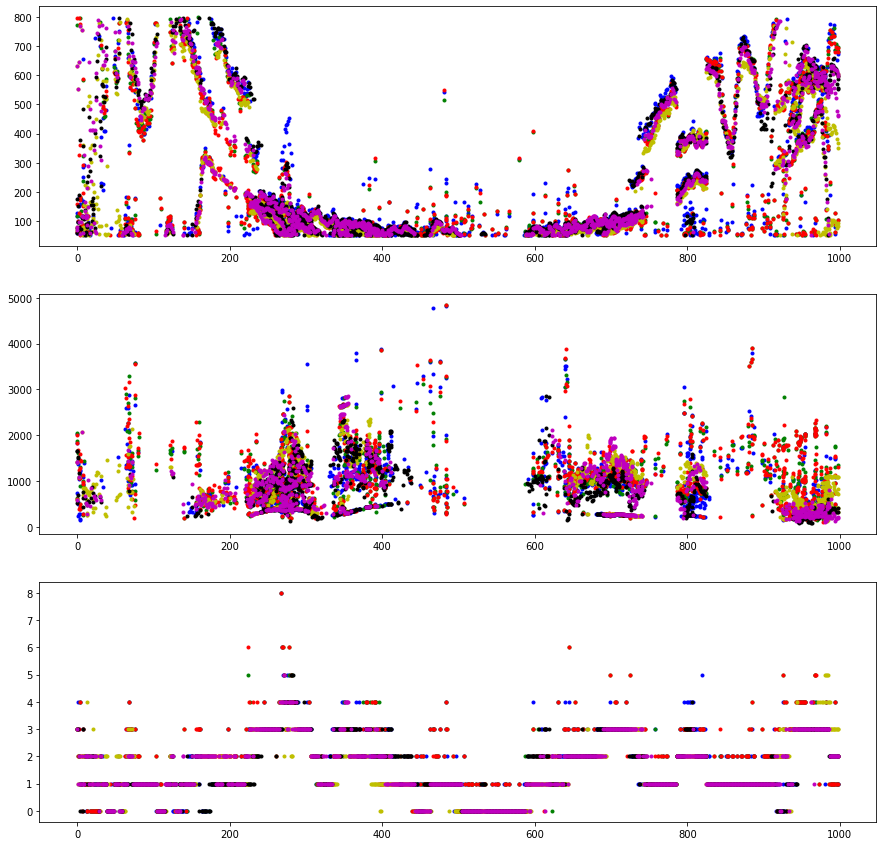

In [66]:
L = {}
A = scipy.io.loadmat('/Users/rsingh/Oyla/Data/RHouse_RHD_March_31_20_00_44//collateral/all.mat')
L['no_filter'] = []
f, axs = plt.subplots(3,1,figsize=(15,15))
for i in range(999): 
    co = A[str(i+1)][2:,:] 
    sz = A[str(i+1)][1,:]
    dist=[] 
    szz = sz[1:][(sz[1:]<800) & (sz[1:]>50)]
    for j in range(0,szz.shape[0]): 
        for k in range(j+1,szz.shape[0]): 
            #if sz[j] <800 and sz[j] >50 and sz[k] <800 and sz[k] >50:
            dist.append(np.sqrt(np.sum((co[:,j]-co[:,k])**2)))
    #print(str(i)+','+str(szz)+','+str(dist[:]) )
    axs[2].plot(i,len(szz),'b.')
    axs[0].plot(np.ones_like(szz)*i,szz,'b.')
    axs[1].plot(np.ones_like(dist)*i,dist,'b.')
    L['no_filter'].append(len(szz))
# A = scipy.io.loadmat('/Users/rsingh/Oyla/Data/RHouse_RHD_March_31_20_00_44//collateral/Test.mat')

# #f, axs = plt.subplots(3,1,figsize=(15,15))
# for i in range(999): 
#     co = A[str(i+1)][2:,:] 
#     sz = A[str(i+1)][1,:]
#     dist=[] 
#     szz = sz[1:][(sz[1:]<800) & (sz[1:]>50)]
#     for j in range(0,szz.shape[0]): 
#         for k in range(j+1,szz.shape[0]): 
#             #if sz[j] <800 and sz[j] >50 and sz[k] <800 and sz[k] >50:
#             dist.append(np.sqrt(np.sum((co[:,j]-co[:,k])**2)))
#     #print(str(i)+','+str(szz)+','+str(dist[:]) )
#     axs[2].plot(i,len(szz),'r.')
#     axs[0].plot(np.ones_like(szz)*i,szz,'r.')
#     axs[1].plot(np.ones_like(dist)*i,dist,'r.')
A = scipy.io.loadmat('/Users/rsingh/Oyla/Data/RHouse_RHD_March_31_20_00_44/filtered_data_July_06_06_14_52_edge_median_50//collateral/Test.mat')
L['filtered_data_July_06_06_14_52_edge_median_50'] = []
#f, axs = plt.subplots(3,1,figsize=(15,15))
for i in range(999): 
    co = A[str(i+1)][2:,:] 
    sz = A[str(i+1)][1,:]
    dist=[] 
    szz = sz[1:][(sz[1:]<800) & (sz[1:]>50)]
    for j in range(0,szz.shape[0]): 
        for k in range(j+1,szz.shape[0]): 
            #if sz[j] <800 and sz[j] >50 and sz[k] <800 and sz[k] >50:
            dist.append(np.sqrt(np.sum((co[:,j]-co[:,k])**2)))
    #print(str(i)+','+str(szz)+','+str(dist[:]) )
    axs[2].plot(i,len(szz),'g.')
    axs[0].plot(np.ones_like(szz)*i,szz,'g.')
    axs[1].plot(np.ones_like(dist)*i,dist,'g.')
    L['filtered_data_July_06_06_14_52_edge_median_50'].append(len(szz))
A = scipy.io.loadmat('/Users/rsingh/Oyla/Data/RHouse_RHD_March_31_20_00_44/filtered_data_July_06_06_29_06_median_outlier/collateral//all.mat')
L['filtered_data_July_06_06_29_06_median_outlier'] = []
#f, axs = plt.subplots(3,1,figsize=(15,15))
for i in range(999): 
    co = A[str(i+1)][2:,:] 
    sz = A[str(i+1)][1,:]
    dist=[] 
    szz = sz[1:][(sz[1:]<800) & (sz[1:]>50)]
    for j in range(0,szz.shape[0]): 
        for k in range(j+1,szz.shape[0]): 
            #if sz[j] <800 and sz[j] >50 and sz[k] <800 and sz[k] >50:
            dist.append(np.sqrt(np.sum((co[:,j]-co[:,k])**2)))
    #print(str(i)+','+str(szz)+','+str(dist[:]) )
    axs[2].plot(i,len(szz),'r.')
    axs[0].plot(np.ones_like(szz)*i,szz,'r.')
    axs[1].plot(np.ones_like(dist)*i,dist,'r.')
    L['filtered_data_July_06_06_29_06_median_outlier'].append(len(szz))
    
A = scipy.io.loadmat('/Users/rsingh/Oyla/Data/RHouse_RHD_March_31_20_00_44/filtered_data_July_06_06_29_06_median_outlier/temporal_filter_8//collateral/Test.mat')
L['filtered_data_July_06_06_29_06_median_outlier_temporal_filter'] = []
#f, axs = plt.subplots(3,1,figsize=(15,15))
for i in range(999): 
    co = A[str(i+1)][2:,:] 
    sz = A[str(i+1)][1,:]
    dist=[] 
    szz = sz[1:][(sz[1:]<800) & (sz[1:]>50)]
    for j in range(0,szz.shape[0]): 
        for k in range(j+1,szz.shape[0]): 
            #if sz[j] <800 and sz[j] >50 and sz[k] <800 and sz[k] >50:
            dist.append(np.sqrt(np.sum((co[:,j]-co[:,k])**2)))
    #print(str(i)+','+str(szz)+','+str(dist[:]) )
    axs[2].plot(i,len(szz),'y.')
    axs[0].plot(np.ones_like(szz)*i,szz,'y.')
    axs[1].plot(np.ones_like(dist)*i,dist,'y.')
    L['filtered_data_July_06_06_29_06_median_outlier_temporal_filter'].append(len(szz))
    
A = scipy.io.loadmat('/Users/rsingh/Oyla/Data/RHouse_RHD_March_31_20_00_44/temporal_filter_8//collateral/Test.mat')
L['temporal_filter_8'] = []
#f, axs = plt.subplots(3,1,figsize=(15,15))
for i in range(999): 
    co = A[str(i+1)][2:,:] 
    sz = A[str(i+1)][1,:]
    dist=[] 
    szz = sz[1:][(sz[1:]<800) & (sz[1:]>50)]
    for j in range(0,szz.shape[0]): 
        for k in range(j+1,szz.shape[0]): 
            #if sz[j] <800 and sz[j] >50 and sz[k] <800 and sz[k] >50:
            dist.append(np.sqrt(np.sum((co[:,j]-co[:,k])**2)))
    #print(str(i)+','+str(szz)+','+str(dist[:]) )
    axs[2].plot(i,len(szz),'k.')
    axs[0].plot(np.ones_like(szz)*i,szz,'k.')
    axs[1].plot(np.ones_like(dist)*i,dist,'k.')
    L['temporal_filter_8'].append(len(szz))

A = scipy.io.loadmat('/Users/rsingh/Oyla/Data/RHouse_RHD_March_31_20_00_44/temporal_filter_8/filtered_data_July_07_18_00_09_median_outlier//collateral/Test.mat')
L['temporal_filter_8_filtered_data_July_07_18_00_09_median_outlier'] = []
#f, axs = plt.subplots(3,1,figsize=(15,15))
for i in range(999): 
    co = A[str(i+1)][2:,:] 
    sz = A[str(i+1)][1,:]
    dist=[] 
    szz = sz[1:][(sz[1:]<800) & (sz[1:]>50)]
    for j in range(0,szz.shape[0]): 
        for k in range(j+1,szz.shape[0]): 
            #if sz[j] <800 and sz[j] >50 and sz[k] <800 and sz[k] >50:
            dist.append(np.sqrt(np.sum((co[:,j]-co[:,k])**2)))
    #print(str(i)+','+str(szz)+','+str(dist[:]) )
    axs[2].plot(i,len(szz),'m.')
    axs[0].plot(np.ones_like(szz)*i,szz,'m.')
    axs[1].plot(np.ones_like(dist)*i,dist,'m.')
    L['temporal_filter_8_filtered_data_July_07_18_00_09_median_outlier'].append(len(szz))


In [40]:
A

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Tue Jul 14 16:18:08 2020',
 '__version__': '1.0',
 '__globals__': [],
 '1': array([[-1.00000000e+00,  0.00000000e+00],
        [ 7.20000000e+02,  9.60000000e+01],
        [ 3.96971661e+02,  1.00522803e+02],
        [-5.03299406e+02,  3.85068594e+01],
        [ 3.88049271e+03,  4.56035979e+02]]),
 '2': array([[-1.00000000e+00,  0.00000000e+00],
        [ 4.88000000e+02,  1.64000000e+02],
        [ 3.36246126e+02,  1.03029480e+02],
        [-5.75097700e+02,  6.09228326e+01],
        [ 4.03416598e+03,  3.08612105e+02]]),
 '3': array([[-1.00000000e+00],
        [ 4.20000000e+02],
        [ 3.09254230e+02],
        [-4.62806519e+02],
        [ 3.44968353e+03]]),
 '4': array([[-1.00000000e+00],
        [ 2.96000000e+02],
        [ 2.16234780e+02],
        [-2.28841459e+02],
        [ 3.43430514e+03]]),
 '5': array([[-1.00000000e+00],
        [ 3.52000000e+02],
        [ 1.60944196e+02],
        [ 1.13848111e+02],
        [ 3.0

In [17]:
pcd = o3d.io.read_point_cloud('/Users/rsingh/Downloads/region_growing_rgb_tutorial.pcd')


In [18]:
o3d.visualization.draw_geometries([pcd])

In [43]:
fp = filtered_phase/30000.0
plt.imsave('/Users/rsingh/Downloads/test.png',fp)

In [44]:
x = plt.imread('/Users/rsingh/Downloads/test.png')

In [45]:
x.shape

(200, 286, 4)

In [46]:
y = np.squeeze(x[:,:,:1])

In [50]:
np.mean(y-fp)

0.17969054

In [49]:
np.max(fp)

0.9945322

In [51]:
fp

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.23682809, 0.2365961 , 0.23401171, ..., 0.25210497, 0.25210497,
        0.25210497],
       [0.2365961 , 0.23559427, 0.23424421, ..., 0.25210497, 0.25210497,
        0.25210497],
       [0.23559427, 0.23559427, 0.23424421, ..., 0.24944307, 0.25210497,
        0.25210497]], dtype=float32)

In [85]:
pcd = o3d.io.read_point_cloud('/Users/rsingh/Downloads/data/out_51.pcd')
X=np.asarray(pcd.points)

In [86]:
X

array([[-0.75193602,  0.55243701,  1.382     ],
       [-0.74961102,  0.55243701,  1.382     ],
       [-0.75052899,  0.55483502,  1.388     ],
       ...,
       [ 0.52791101, -0.410698  ,  0.        ],
       [ 0.529594  , -0.410698  ,  0.        ],
       [ 0.531277  , -0.410698  ,  0.        ]])

In [25]:
pcd.colors = o3d.utility.Vector3dVector(np.hstack((_r,_g,_b)).reshape((len(_r),3)))

np.asarray(pcd.colors)

array([[0.4627451 , 0.47843137, 0.49019608],
       [0.49803922, 0.50588238, 0.51372552],
       [0.52156866, 0.5411765 , 0.5529412 ],
       ...,
       [0.25490198, 0.2       , 0.21176471],
       [0.23529412, 0.23529412, 0.27450982],
       [0.21568628, 0.20784314, 0.25882354]])

In [28]:
o3d.visualization.draw_geometries([pcd])

In [27]:
o3d.io.write_point_cloud('/Users/rsingh/Downloads/test.pcd',pcd)

True

In [ ]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(features)
o3d.visualization.draw_geometries([pcd])

In [39]:
A = scipy.io.loadmat('/Users/rsingh/Oyla/DData/SocDistTestShots_data_August_17_20_15_21/oyla_output_fs_cds_spatialMedian_pclOutliers/depth_0015.mat')
#B = scipy.io.loadmat('/Users/rsingh/Oyla/DData/RHouse_RH_February_07_18_54_22/oyla_output/2d/depth/oyla_0118.mat')

In [40]:
np.count_nonzero(A['dist'])

43809

In [41]:
pcd = o3d.io.read_point_cloud('/Users/rsingh/Oyla/DData/SocDistTestShots_data_August_17_20_15_21/oyla_output_fs_cds_spatialMedian_pclOutliers/pcl_0015.xyz')

In [42]:
pcd

geometry::PointCloud with 43809 points.

In [43]:
A = scipy.io.loadmat('/Users/rsingh/Oyla/DData/SocDistTestShots_data_August_17_20_15_21/oyla_output_fs_cds_spatialMedian_pclOutliers//depth_0115.mat')
#B = scipy.io.loadmat('/Users/rsingh/Oyla/DData/RHouse_RH_February_07_18_54_22/oyla_output/2d/depth/oyla_0118.mat')

In [44]:
np.count_nonzero(A['dist'])

43640

In [45]:
pcd = o3d.io.read_point_cloud('/Users/rsingh/Oyla/DData/SocDistTestShots_data_August_17_20_15_21/oyla_output_fs_cds_spatialMedian_pclOutliers/pcl_0115.xyz')

In [46]:
pcd

geometry::PointCloud with 43640 points.

In [47]:
A = scipy.io.loadmat('/Users/rsingh/Oyla/DData/SocDistTestShots_data_August_17_20_15_21/oyla_output_fs_cds_spatialMedian_pclOutliers/depth_0237.mat')
#B = scipy.io.loadmat('/Users/rsingh/Oyla/DData/RHouse_RH_February_07_18_54_22/oyla_output/2d/depth/oyla_0118.mat')

In [48]:
np.count_nonzero(A['dist'])

43412

In [49]:
pcd = o3d.io.read_point_cloud('/Users/rsingh/Oyla/DData/SocDistTestShots_data_August_17_20_15_21/oyla_output_fs_cds_spatialMedian_pclOutliers/pcl_0237.xyz')

In [50]:
pcd

geometry::PointCloud with 43412 points.

In [55]:
A = scipy.io.loadmat('/Users/rsingh/Oyla/DData/SocDistTestShots_data_August_17_20_15_21/oyla_output_fs_cds_spatialMedian_pclOutliersrM_2200am_100xM_270.0/////depth_0015.mat')
#B = scipy.io.loadmat('/Users/rsingh/Oyla/DData/RHouse_RH_February_07_18_54_22/oyla_output/2d/depth/oyla_0118.mat')

In [56]:
np.count_nonzero(A['dist'])

3012

In [57]:
pcd = o3d.io.read_point_cloud('/Users/rsingh/Oyla/DData/SocDistTestShots_data_August_17_20_15_21/oyla_output_fs_cds_spatialMedian_pclOutliersrM_2200am_100xM_270.0////pcl_0015.xyz')

In [58]:
pcd

geometry::PointCloud with 3012 points.

In [37]:
o3d.visualization.draw_geometries([pcd])

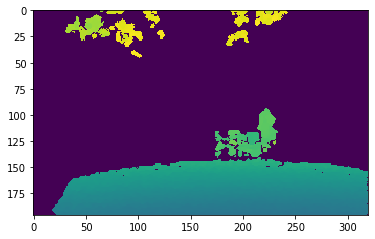

In [38]:
plt.imshow(A['dist'])

In [36]:
A['data'][0][2][0][0].shape

KeyError: 'data'

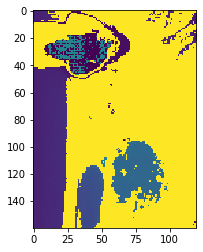

In [24]:
plt.imshow(A['data'][0][2][0][0][:,:,0])

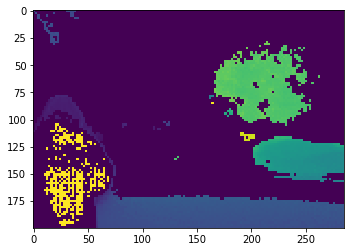

In [25]:
plt.imshow(B['dist'])

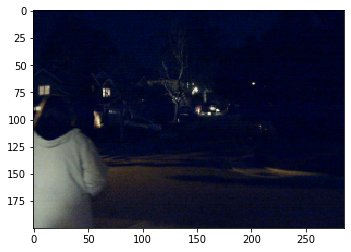

In [26]:
plt.imshow(plt.imread('/Users/rsingh/Oyla/Data/RHouse_RH_February_07_18_54_22/oyla_output/2d/rgb/oyla_0118.png'))

In [27]:
C = scipy.io.loadmat('/Users/rsingh/Oyla/Data/RHouse_RH_February_07_18_54_22/oyla_output_outlier/2d/depth/oyla_0118.mat')

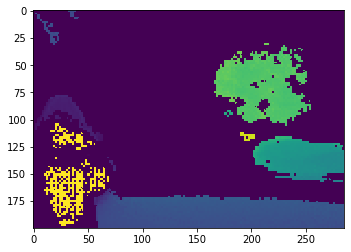

In [28]:
plt.imshow(C['dist'])

In [29]:
D = scipy.io.loadmat('/Users/rsingh/Oyla/Data/RHouse_RH_February_07_18_54_22/oyla_output_temporal_outlier//2d/depth/oyla_0118.mat')

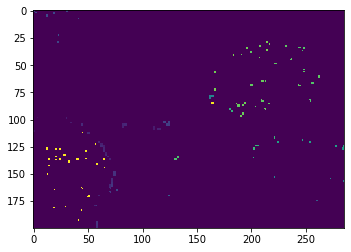

In [34]:
plt.imshow(np.abs(C['dist']-B['dist']))

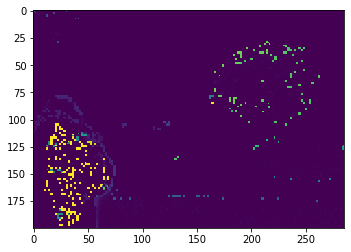

In [35]:
plt.imshow(np.abs(D['dist']-B['dist']))

In [43]:
E = scipy.io.loadmat('/Users/rsingh/Oyla/Data/RHouse_RH_February_07_18_54_22/temporal_filter_8/filtered_data_July_14_17_25_08_outlier/data_filtered_119.mat')

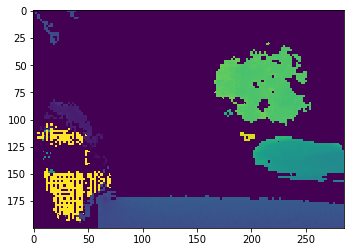

In [44]:
plt.imshow(np.abs(E['data'][0][2][0][0][:,:,0]))

In [41]:
E['data'][0][2][0][0].shape

(200, 286, 2)

In [45]:
    pcd = o3d.io.read_point_cloud('/Users/rsingh/Oyla/Data/RHouse_RH_February_07_18_54_22/oyla_output_temporal_outlier//3d/oyla_0118.xyz')

In [46]:
o3d.visualization.draw_geometries([pcd])

In [49]:
np.where(D['dist']!=0)[0].shape

(15251,)

In [50]:
np.asarray(pcd.points).shape

(15251, 3)